In [1]:
import os
import pickle
import torch
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [3]:
class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.permutations(authors, 2):
                    self.graph[u].add(v)
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Lógica de Amigos em Comum (2 hops)
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(recommendations) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= top_n:
                        break
                        
        return recommendations[:top_n]


In [4]:
class ContentSciBERTRecommender(BaseRecommender):
    def __init__(self, model_name='allenai/scibert_scivocab_uncased', cache_path='scibert_embeddings.pkl'):
        super().__init__("Content-Based (SciBERT)")
        self.model_name = model_name
        self.cache_path = cache_path
        self.encoder = None
        self.author_embeddings = {} 
        self.knn_model = None
        self.author_ids_index = []
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"[{self.name}] Device selecionado: {self.device.upper()}")
        
    def fit(self, train_df):
        work_id_to_emb = self._load_embeddings()
        
        unique_works = train_df[['work_id', 'title', 'abstract']].drop_duplicates()
        
        if work_id_to_emb is None:
            print(f"[{self.name}] Gerando embeddings na {self.device.upper()}...")
            self.encoder = SentenceTransformer(self.model_name, device=self.device)
            
            unique_works['text'] = unique_works['title'] + ". " + unique_works['abstract'].fillna('')
            
            work_embeddings = self.encoder.encode(
                unique_works['text'].tolist(), 
                batch_size=32, 
                show_progress_bar=True,
                device=self.device
            )
            
            work_id_to_emb = {wid: emb for wid, emb in zip(unique_works['work_id'], work_embeddings)}
            self._save_embeddings(work_id_to_emb)
        else:
            print(f"[{self.name}] Embeddings carregados do cache.")

        print(f"[{self.name}] Consolidadando perfis de autores...")
        
        author_groups = train_df.groupby('author_id')['work_id'].apply(list)
        
        author_vectors = []
        self.author_ids_index = []
        
        for author_id, work_ids in author_groups.items():
            vectors = [work_id_to_emb[wid] for wid in work_ids if wid in work_id_to_emb]
            
            if vectors:
                mean_vector = np.mean(vectors, axis=0)
                author_vectors.append(mean_vector)
                self.author_ids_index.append(author_id)
        
        self.author_embeddings = np.array(author_vectors)
        
        # O KNN do scikit-learn roda em CPU, mas é muito rápido para vetores já prontos
        self.knn_model = NearestNeighbors(n_neighbors=50, metric='cosine', n_jobs=-1)
        self.knn_model.fit(self.author_embeddings)
        print(f"[{self.name}] Treino finalizado. {len(self.author_ids_index)} perfis.")

    def recommend(self, author_id, top_n=10):
        try:
            author_idx = self.author_ids_index.index(author_id)
        except ValueError:
            return []
            
        author_vector = self.author_embeddings[author_idx].reshape(1, -1)
        distances, indices = self.knn_model.kneighbors(author_vector, n_neighbors=top_n+1)
        
        recommendations = []
        for idx in indices[0]:
            rec_author = self.author_ids_index[idx]
            if rec_author != author_id:
                recommendations.append(rec_author)
                
        return recommendations[:top_n]
    
    def get_author_vector(self, author_id):
        try:
            idx = self.author_ids_index.index(author_id)
            return self.author_embeddings[idx]
        except ValueError:
            return None

    def _save_embeddings(self, data):
        with open(self.cache_path, 'wb') as f:
            pickle.dump(data, f)

    def _load_embeddings(self):
        if os.path.exists(self.cache_path):
            with open(self.cache_path, 'rb') as f:
                return pickle.load(f)
        return None

In [5]:
class HybridRecommender(BaseRecommender):
    def __init__(self, topology_model, content_model, alpha=0.8):
        """
        alpha: Peso dado ao modelo de Topologia (0.0 a 1.0).
               Se alpha=0.8, vale 80% Topologia e 20% Conteúdo.
               Dado que Topologia performou melhor, recomendo alpha alto (0.7 a 0.9).
        """
        super().__init__("Hybrid (Topology + Content)")
        self.topo_model = topology_model
        self.content_model = content_model
        self.alpha = alpha
        
    def fit(self, train_df):
        if not self.topo_model.graph:
            self.topo_model.fit(train_df)
        if len(self.content_model.author_embeddings) == 0:
            self.content_model.fit(train_df)
            
    def recommend(self, author_id, top_n=10):
        pool_size = top_n * 3 
        
        topo_candidates = {}
        if author_id in self.topo_model.graph:
            current_coauthors = self.topo_model.graph[author_id]
            candidates = []
            for neighbor in current_coauthors:
                for candidate in self.topo_model.graph.get(neighbor, set()):
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            topo_counts = Counter(candidates)
            if topo_counts:
                max_count = max(topo_counts.values())
                topo_candidates = {auth: count/max_count for auth, count in topo_counts.items()}

        content_candidates = {}
        if author_id in self.content_model.author_ids_index:
            try:
                auth_idx = self.content_model.author_ids_index.index(author_id)
                auth_vec = self.content_model.author_embeddings[auth_idx].reshape(1, -1)
                
                dists, indices = self.content_model.knn_model.kneighbors(auth_vec, n_neighbors=pool_size)
                
                for d, idx in zip(dists[0], indices[0]):
                    rec_auth = self.content_model.author_ids_index[idx]
                    if rec_auth != author_id:
                        sim_score = 1.0 - d 
                        content_candidates[rec_auth] = sim_score
            except:
                pass

        final_scores = defaultdict(float)
        
        all_candidates = set(topo_candidates.keys()) | set(content_candidates.keys())
        
        for cand in all_candidates:
            score_t = topo_candidates.get(cand, 0.0)
            score_c = content_candidates.get(cand, 0.0)
            
            final_scores[cand] = (self.alpha * score_t) + ((1 - self.alpha) * score_c)
            
        sorted_recs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
        
        return [auth for auth, score in sorted_recs[:top_n]]

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

class HybridRecommenderFilter(BaseRecommender):
    def __init__(self, topology_model, content_model, filter_k=50):
        """
        filter_k: Quantos candidatos a topologia deve buscar inicialmente.
                  Quanto maior, mais chance do Content Model encontrar alguém relevante que estava 'escondido' lá embaixo na lista.
        """
        super().__init__("Hybrid (Topo Filter + Content Rank)")
        self.topo_model = topology_model
        self.content_model = content_model
        self.filter_k = filter_k
        
    def fit(self, train_df):
        pass

    def recommend(self, author_id, top_n=10):
        candidates = self.topo_model.recommend(author_id, top_n=self.filter_k)
        
        if not candidates:
            return []
            
        source_vector = self.content_model.get_author_vector(author_id)
        
        if source_vector is None:
            return candidates[:top_n]
            
        candidate_scores = []
        
        for cand_id in candidates:
            cand_vector = self.content_model.get_author_vector(cand_id)
            
            if cand_vector is not None:
                sim = cosine_similarity(source_vector.reshape(1, -1), cand_vector.reshape(1, -1))[0][0]
                candidate_scores.append((cand_id, sim))
            else:
                candidate_scores.append((cand_id, -1))
        
        candidate_scores.sort(key=lambda x: x[1], reverse=True)
        
        final_recs = [cand for cand, score in candidate_scores]
        return final_recs[:top_n]

In [7]:
def calculate_ndcg(recommended_list, relevant_set, k):
    """
    Calcula o NDCG@k (Normalized Discounted Cumulative Gain).
    
    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número de itens a considerar (top-k)
    
    Returns:
        NDCG@k score (0.0 a 1.0)
    """
    if len(relevant_set) == 0:
        return 0.0
    
    # DCG: Discounted Cumulative Gain
    dcg = 0.0
    for i, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            dcg += 1.0 / np.log2(i + 1)
    
    # IDCG: Ideal DCG (ordenando os relevantes primeiro)
    idcg = 0.0
    num_relevant = min(len(relevant_set), k)
    for i in range(1, num_relevant + 1):
        idcg += 1.0 / np.log2(i + 1)
    
    # NDCG = DCG / IDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg


def calculate_mrr_at_k(recommended_list, relevant_set, k):
    """
    Calcula o MRR@k (Mean Reciprocal Rank at k).
    
    O MRR@k só considera o primeiro item relevante se ele aparecer dentro das 
    primeiras k posições. Se o primeiro relevante aparecer após a posição k, 
    o MRR@k é 0.
    
    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número máximo de posições a considerar (top-k)
    
    Returns:
        Reciprocal Rank@k (1/rank do primeiro relevante dentro de k, ou 0 se nenhum relevante)
    """
    if len(relevant_set) == 0:
        return 0.0
    
    # Considera apenas as primeiras k posições
    for rank, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            return 1.0 / rank
    
    return 0.0


def evaluate_models(models, test_ground_truth, train_graph_check, K_values=[5, 10]):
    results = {}
    
    for model in models:
        print(f"\nAvaliando modelo: {model.name}...")
        model_metrics = {k: {'precision': [], 'recall': [], 'ndcg': [], 'mrr': []} for k in K_values}
        
        for author_id, actual_new_coauthors in test_ground_truth.items():
            max_k = max(K_values)
            recs = model.recommend(author_id, top_n=max_k)
            
            past_coauthors = train_graph_check.get(author_id, set())
            recs = [r for r in recs if r not in past_coauthors]
            
            for k in K_values:
                top_k_recs = recs[:k]
                hits = len(set(top_k_recs) & actual_new_coauthors)
                
                p = hits / k if k > 0 else 0
                r = hits / len(actual_new_coauthors) if len(actual_new_coauthors) > 0 else 0
                ndcg = calculate_ndcg(top_k_recs, actual_new_coauthors, k)
                mrr = calculate_mrr_at_k(recs, actual_new_coauthors, k)
                
                model_metrics[k]['precision'].append(p)
                model_metrics[k]['recall'].append(r)
                model_metrics[k]['ndcg'].append(ndcg)
                model_metrics[k]['mrr'].append(mrr)
        
        # Média final
        results[model.name] = {}
        
        for k in K_values:
            avg_p = np.mean(model_metrics[k]['precision'])
            avg_r = np.mean(model_metrics[k]['recall'])
            avg_ndcg = np.mean(model_metrics[k]['ndcg'])
            avg_mrr = np.mean(model_metrics[k]['mrr'])
            f1 = 2 * (avg_p * avg_r) / (avg_p + avg_r) if (avg_p + avg_r) > 0 else 0
            
            results[model.name][k] = {'P': avg_p, 'R': avg_r, 'F1': f1, 'NDCG': avg_ndcg, 'MRR': avg_mrr}
            print(f"  K={k}: Precision={avg_p:.4f}, Recall={avg_r:.4f}, F1={f1:.4f}, NDCG={avg_ndcg:.4f}, MRR@k={avg_mrr:.4f}")
            
    return results

In [8]:
def plot_model_comparison(results, figsize=(25, 5)):
    model_names = list(results.keys())
    k_values = sorted([k for k in results[model_names[0]].keys() if isinstance(k, int)])
    
    # Preparar dados para cada métrica
    metrics_data = {
        'Precision': {model: [results[model][k]['P'] for k in k_values] for model in model_names},
        'Recall': {model: [results[model][k]['R'] for k in k_values] for model in model_names},
        'F1-Score': {model: [results[model][k]['F1'] for k in k_values] for model in model_names},
        'NDCG': {model: [results[model][k]['NDCG'] for k in k_values] for model in model_names},
        'MRR@k': {model: [results[model][k]['MRR'] for k in k_values] for model in model_names}
    }
    
    # Criar figura com 5 subplots para métricas dependentes de K
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    fig.suptitle('Comparação de Modelos de Link Prediction', fontsize=16, fontweight='bold')
    
    # Cores e estilos para cada modelo
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Plotar cada métrica dependente de K
    for idx, (metric_name, data) in enumerate(metrics_data.items()):
        ax = axes[idx]
        
        for i, model in enumerate(model_names):
            ax.plot(
                k_values, 
                data[model], 
                marker=markers[i % len(markers)],
                label=model,
                color=colors[i % len(colors)],
                linewidth=2,
                markersize=8
            )
        
        ax.set_xlabel('K (Top-K)', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} por K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        ax.set_xticks(k_values)
        
    plt.tight_layout()
    plt.show()
    
    return fig

In [9]:
database_path = 'database_50k'
authors_df = pd.read_csv(f'{database_path}/authorships.csv')
works_df = pd.read_csv(f'{database_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele já conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_4160\1540647326.py:3: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{database_path}/works.csv')


[Content-Based (SciBERT)] Device selecionado: CUDA
[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 25260 autores.

Avaliando modelo: Topology (Graph Coauthor)...
  K=20: Precision=0.0158, Recall=0.0431, F1=0.0231, NDCG=0.0298, MRR@k=0.0525

Avaliando modelo: Hybrid (Topo Filter + Content Rank)...
  K=20: Precision=0.0158, Recall=0.0431, F1=0.0231, NDCG=0.0298, MRR@k=0.0525


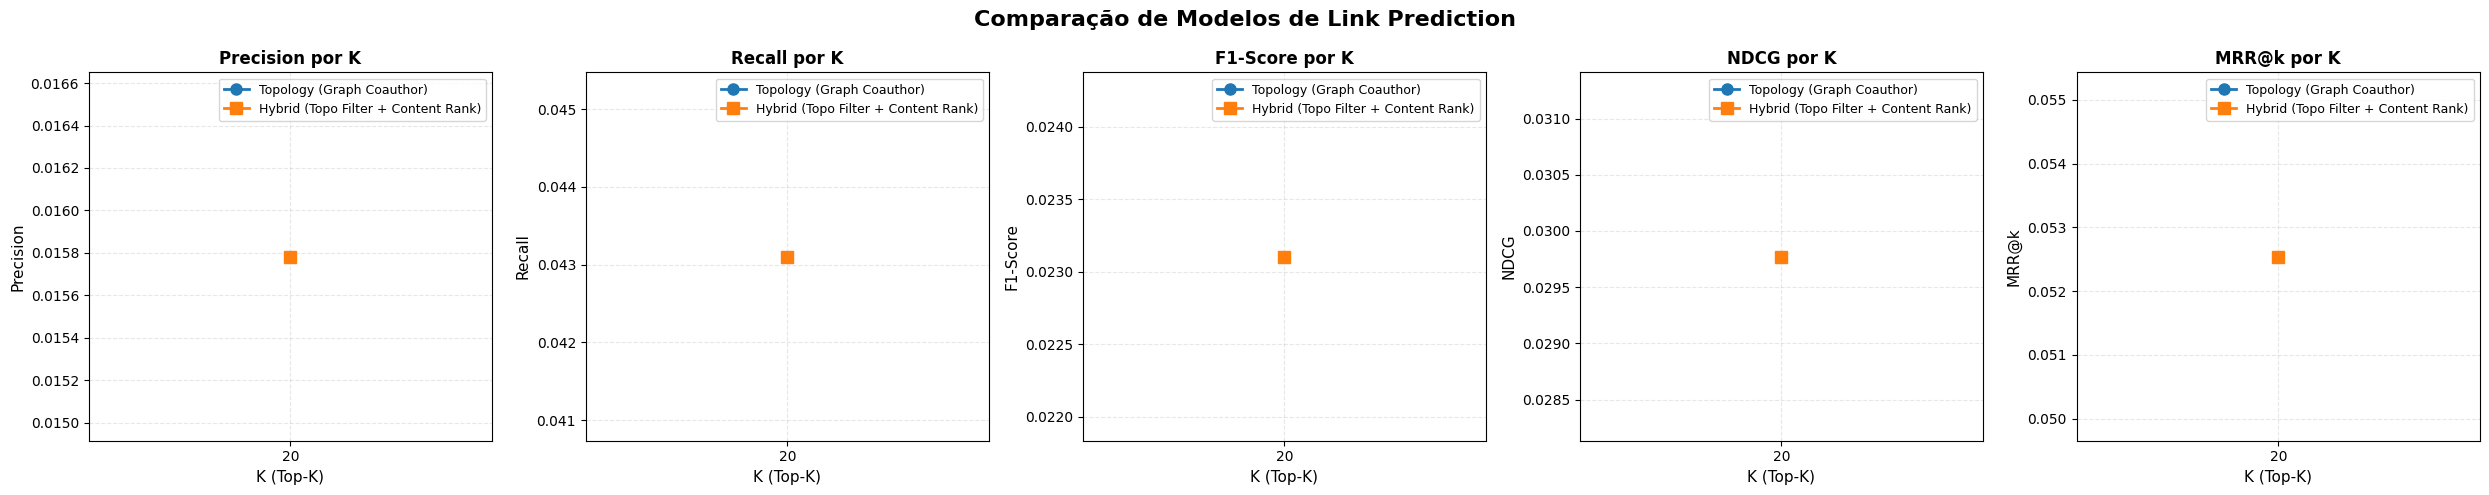

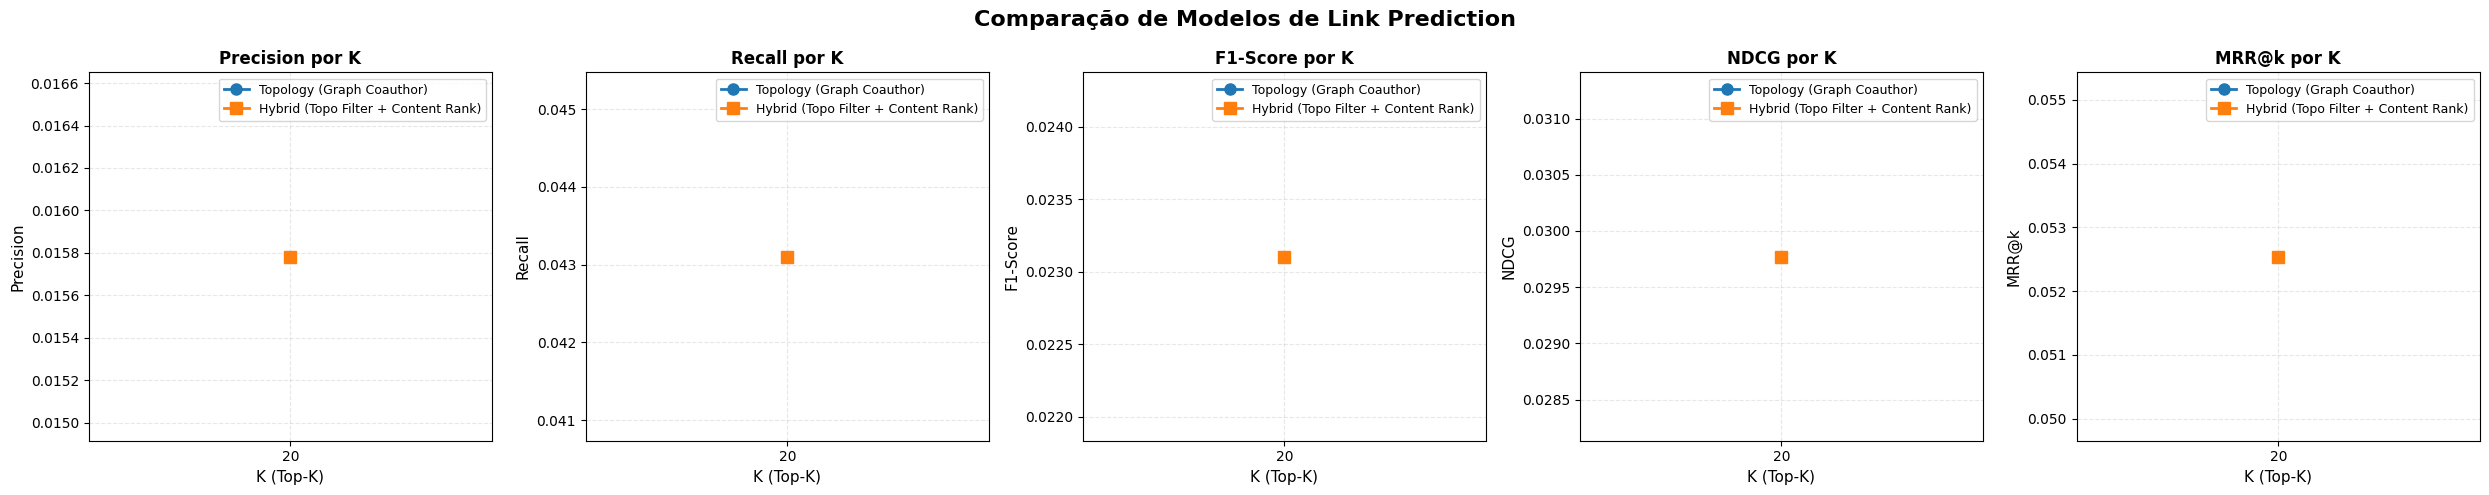

In [10]:
topo_model = TopologyRecommender()
content_model = ContentSciBERTRecommender(model_name='allenai/scibert_scivocab_uncased', cache_path=f'{database_path}/scibert_embeddings.pkl')
hybrid_model = HybridRecommender(topo_model, content_model, alpha=0.8)
hybrid_model_filter = HybridRecommenderFilter(topo_model, content_model, filter_k=20)

models = [
    topo_model, 
    # content_model, 
    # hybrid_model, 
    hybrid_model_filter
]

for model in models:
    model.fit(train_df) 
    
metrics = evaluate_models(models, test_ground_truth, train_graph, K_values=[20])
plot_model_comparison(metrics)